In [57]:
""" This code is meant to explore the comparison against the crawler processed elevation data and the data
recoreded external to """
import sys
sys.path.append('/home/spike/repos')
from testbedutils import geoprocess as gp
import datetime as DT
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from pygeodesy import geoids

%matplotlib inline

# define functions that are useful 

In [58]:

def readHypackRAW(fname):
    # open hypack raw file and key on "msg" line containing raw GPS string
    fc = open(fname)
    
    time_RTN,lat_RTN,long_RTN,ellipsoid_RTN = [],[],[],[]
    
    
    for line in fc:
        if line.startswith("MSG"):
            msg = line.split(',')
            if  msg[8]== '3': # msg[0][4]== '1' and the 3 is indicator that point is RTK fixed
                time_RTN.append(float(msg[2])) # extracting UTC time
                lat_degree_RTN = msg[4][0:2]
                lat_minute_RTN = msg[4][2::]
                lat_decimal_min_RTN = float(lat_minute_RTN)/60 + float(lat_degree_RTN)
                dd_lat_RTN = lat_decimal_min_RTN
                lat_RTN.append(dd_lat_RTN)
                long_degree_RTN = msg[6][0:3]
                long_minute_RTN = msg[6][3::]
                long_decimal_min_RTN = float(long_minute_RTN)/60 + float(long_degree_RTN)
                long_decimal_min = long_decimal_min_RTN *-1
                long_RTN.append(-long_decimal_min_RTN)
                ellipsoid_RTN.append(float(msg[11][3::]))
    fc.close()
    
    # now place into pandas data frame
    df = pd.DataFrame(list(zip(time_RTN, lat_RTN, long_RTN, ellipsoid_RTN)), columns=['time', 'latitude', 'longitude',
                                                                                 'ellipsoid'])
    return df

def correctEllipsoid(fname, geoidFile='g2012bu8.bin', plot=False):
    """ This function loads the csv file that is output by the greensea software and will correct the GGA string
    elevations and geiod to the 2012B geoid that is commonly used at the FRF.  It does this by taking the elevation
    from the GGA string, subtracting the GGA string geoid, leaving you with raw ellipsoid value.  That ellipsoid
    value is then corrected with the 2012B geoid that is commonly used at the FRF.
    
    NOTE: if this is the first time you're using this, you'll likely have to go get the geoid bin file.  Code was
        developed using the uncompressed bin file.  It is unclear if the pygeodesy library requires the bin file to
        be uncompressed.  https://geodesy.noaa.gov/GEOID/GEOID12B/GEOID12B_CONUS.shtml
        
    Args:
        fname: input file to be corrected
        geoidFile: location of your geoidfile (default='g2012bu8.bin')
        plot: show an xy scatter plot with elevations
        
    Returns:
         a pandas object with original and corrected values
         
    """
    
    data = pd.read_csv(fname, header=4)
    data['ellipsoid'] = data.gga_altitude_m + data.gga_height_geoid_m
    instance = geoids.GeoidG2012B(geoidFile)
    geoidHeight = instance.height(data.latitude, data.longitude)
    data['elevation_NAVD88_m'] = data.ellipsoid - geoidHeight
    if plot is True:
        data.plot.scatter('longitude', 'latitude', c='elevation_NAVD88_m', cmap='ocean')
    
    return data

def cleanDF(data):
    """cleans data frame by removing columns with all zeros and converts time"""
    for key in data.keys():
        if (data[key] == 0).all():
            data.drop(columns=key, inplace=True)
    data['time'] = pd.to_datetime(data['UNIX_timestamp'], unit='s')
    return data

# now load both data from bathy crawler and hypack 

In [59]:
# identify hypack raw recorded file
inputFile = '/home/spike/repos/bathyCrawler/data/BaseTest/0000_1501.RAW'

df = readHypackRAW(inputFile)  # read it 
# now convert to local coordinate system [x=shore perpendicular, y=shore parallel]
coords = gp.FRFcoord(df.longitude.to_numpy(), df.latitude.to_numpy(),  coordType='LL')
df['xFRF'] = coords['xFRF']
df['yFRF'] = coords['yFRF']

# now generate avg x, y, z values from hypack file
h_mean_x = df.xFRF.mean()
h_mean_y = df.yFRF.mean()
h_mean_z = df.ellipsoid.mean()


In [66]:
# now identify, load crawler files, convert to local coordinate system 
crawlerFname = "data/BaseTest/20211122_200137.386_telemetry.gssbin_GPS_STAT_2.csv"
# takes elevation from GGA string and converts back to raw elipsoid value (with 2012b NAD83 geoid model)
data = correctEllipsoid(crawlerFname, geoidFile='data/g2012bu8.bin') 
# removes columns that are all zeros
data = cleanDF(data)
# convert Lat/Lon to local coordinat system 
coords = gp.FRFcoord(data.longitude.to_numpy(), data.latitude.to_numpy())
data['xFRF'] = coords['xFRF']
data['yFRF'] = coords['yFRF']

## now generate avg x, y, z values from crawler 
c_mean_x = data.xFRF.mean()
c_mean_y = data.yFRF.mean()
c_mean_z = data.ellipsoid.mean()


In [61]:
print(f"residual in x {c_mean_x - h_mean_x:.4f} m")
print(f"residual in y {c_mean_y - h_mean_y:.4f} m")
print(f"residual in z {c_mean_z - h_mean_z:.4f} m")


residual in x 0.0001 m
residual in y -0.0000 m
residual in z -0.0001 m


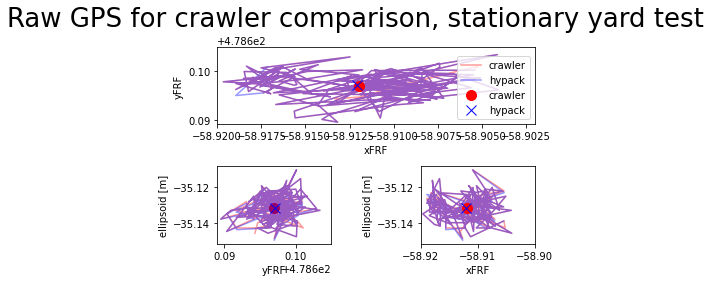

In [67]:
plt.figure()
plt.suptitle('Raw GPS for crawler comparison, stationary yard test\n', fontsize=26)
ax1 = plt.subplot(2,1,1)
ax1.plot(data.xFRF, data.yFRF, color='r', alpha=0.4, label='crawler')
ax1.plot(df.xFRF, df.yFRF, color='b', alpha=0.4, label='hypack')
ax1.plot(c_mean_x, c_mean_y, 'ro', ms=10, label='crawler')
ax1.plot(h_mean_x, h_mean_y, 'bx', ms=10, label='hypack')
ax1.set_ylabel('yFRF')
ax1.set_xlabel('xFRF')
ax1.set_xlim([-58.92, -58.902])
ax1.set_ylim([478.689, 478.705])
ax1.legend()


ax2 = plt.subplot(224)
ax2.plot(data.xFRF, data.ellipsoid, color='r', alpha=.4, label='crawler')
ax2.plot(df.xFRF, df.ellipsoid, color='b', alpha=0.4, label='hypack')

ax2.plot(c_mean_x, c_mean_z, 'ro', ms=10, label='crawler')
ax2.plot(h_mean_x, h_mean_z, 'bx', ms=10, label='hypack')
ax2.set_ylabel('ellipsoid [m]')
ax2.set_xlabel('xFRF')
ax2.set_xlim([-58.92, -58.90])

ax3 = plt.subplot(223)
ax3.plot(data.yFRF, data.ellipsoid, color='r', alpha=.4, label='crawler')
ax3.plot(c_mean_y, c_mean_z, 'ro', ms=10, label='crawler')
ax3.plot(df.yFRF, df.ellipsoid, color='b', alpha=0.4,  label='hypack')
ax3.plot(h_mean_y, h_mean_z, 'bx', ms=10, label='hypack')

ax3.set_ylabel('ellipsoid [m]')
ax3.set_xlabel('yFRF')
ax3.set_xlim([478.689, 478.705])
plt.tight_layout(rect=[0.01,0.01,0.99,0.89])